In [1]:
from filterpy.monte_carlo import systematic_resample
import numpy as np
from scipy.stats import norm
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import os

## Set Particle Filter's Parameters

Set the model's parameters

`num_particles`: Sets the number of particles used in the model, more particles will produce more accurate results but will be more computationally expensive 

`measurement_noise`: The per observation uncertainty, tradeoff between the model's bias and variance.

`std_dev_increase`: optional variable to increase the variablilty by round, typically set to zero

In [2]:
# set model parameters
num_particles = 20_000

measurement_noise = 3_250
std_dev_increase = 000

In [3]:
# set prior distribution parameters for particles
particles = np.zeros((num_particles, 1))
weights = np.ones(num_particles) / num_particles

initial_pot_guess = 245_782
pot_guess_std = 60_000

particles = np.random.normal(
    loc=initial_pot_guess, scale=pot_guess_std, size=num_particles
)
prior_distribution = particles.copy()

## Set Simulation Parameters
Set an arbitary "true pot size", as the `true_pot_value`, that the bids will be simulated from. Each team will have a slightly different model with slightly different estimated pot size that each team will win **and** different estimates of the pot size, creating two sources of uncertainty. However, since most teams are pulling their win probabilities from the same ~3 sources, we can treat these as constants and increase the `bid_std` variable to account for the uncertainty contributed by both sources of error.  

In [4]:
# set simulation parameters
true_pot_value = 264_750
bid_std = 0.10
n_bids = 48
n_simulations = 30
min_bid_value = 700

implied_min_pot_share = min_bid_value / true_pot_value

# cumulative bid unique parameters
cumulative_bid_std = 0.10

## Define General Particle Filter Functions

In [5]:
# prediction function to simulate particle evolution
def predict(particles, std_dev_increase):
    particles += np.random.normal(0, std_dev_increase, num_particles)


# resample the particles
def resample(particles, weights):
    indices = systematic_resample(weights)
    particles[:] = particles[indices]
    weights.fill(1.0 / num_particles)


# return an estimate of the pot as the weighted averaged of the posterior distribution
def estimate(particles, weights):
    return np.average(particles, weights=weights, axis=0)


# reset the particles, for use during simulation
def reset_model(initial_pot_guess, pot_guess_std, num_particles):
    particles = np.random.normal(
        loc=initial_pot_guess, scale=pot_guess_std, size=num_particles
    )
    weights = np.ones(num_particles) / num_particles
    return particles, weights

## Define the Per Bid, Particle Filter Functions

In [6]:
# define a function to map predicted pot sizes to predicted bids
def bid_to_pot_size(pot_size, share_of_pot):
    return pot_size * share_of_pot


def per_bid_update(particles, weights, observed_bid, share_of_pot, measurement_noise):
    predicted_bids = bid_to_pot_size(particles, share_of_pot)

    # Calculate likelihood for each particle vectorized.
    likelihoods = norm.pdf(observed_bid, loc=predicted_bids, scale=measurement_noise)

    # Update weights by multiplying with likelihoods directly, element-wise.
    weights *= likelihoods

    # Re-normalize weights to sum to 1.
    weights /= np.sum(weights)


# wrap together filter helpher functions into one function
def per_bid_particle_filter(
    particles, weights, std_dev_increase, measurement_noise, observed_bids, share_of_pot
):
    estimates = []
    for observed_bid, assumed_share in zip(observed_bids, share_of_pot):
        predict(particles, std_dev_increase)
        per_bid_update(
            particles, weights, observed_bid, assumed_share, measurement_noise
        )
        resample(particles, weights)
        pot_estimate = estimate(particles, weights)
        estimates.append(pot_estimate)
    return np.array(estimates), particles

## Define the Cumulative Bid Model

In [7]:
# increment the pot size and pot fraction observed
def cumulative_pot_fraction(
    observed_bid, share_of_pot, live_pot_size=0, live_pot_share=0
):
    live_pot_share += share_of_pot
    live_pot_size += observed_bid
    return live_pot_size, live_pot_share


# calculate implied pot size based on percentage of pot shares observed so far
def implied_pot_size(est_pot_size, live_pot_share):
    return est_pot_size / live_pot_share


# estimate remaining pot conditional on the fraction of the pot observed thus far
def cumulative_pot_prediction(observed_bids, pot_shares):
    # intialize list and seed values for pot size and share
    estimates = []
    live_pot_size = 0
    live_pot_share = 0

    # track the size of the pot outstanding and infer total pot size
    for observed_bid, share_of_pot in zip(observed_bids, pot_shares):
        live_pot_size, live_pot_share = cumulative_pot_fraction(
            observed_bid, share_of_pot, live_pot_size, live_pot_share
        )
        pot_estimate = implied_pot_size(live_pot_size, live_pot_share)
        estimates.append(pot_estimate)
    return np.array(estimates)

## Define the Ensemble Model

In [8]:
# take a weighted average of the two model's estimates, with relative error contribution as weights
def ensemble_model(y_hat_1: np.array, y_hat_2: np.array, weights: np.array):
    scaled_y_hat_1 = weights * y_hat_1
    scaled_y_hat_2 = (1 - weights) * y_hat_2

    return scaled_y_hat_1 + scaled_y_hat_2

## Simulations

### Run the per bid simulation

#### Simulation strategy 
1. Generate `n_bids` random values from a uniform distribution
2. Normalize these values to sum to one 
3. Where shares are less than the pre-determined threshold, `implied_min_bid_value`, inflate them 
4. Re-normalize share values 
5. Generate bids as `share_of_pot` x `total_pot_size` + normally distributed noise


In [9]:
def generate_bids_with_negative_binomial_and_min_noise(
    n_teams,
    true_pot_value,
    min_bid_value,
    alpha=0.8,
    r=1.0,
    p=0.5,
    bid_noise_percentage=0.05,
    min_bid_noise_percentage=0.05,
):
    """
    Generates simulated bids using a Negative Binomial distribution and ensures all bids meet a minimum value,
    with added noise for variance, including for bids at the minimum threshold.

    Parameters:
    - n_teams: Number of teams (bids).
    - true_pot_value: The total value of the pot.
    - min_bid_value: The minimum value that any bid should have.
    - alpha: Parameter to scale the shares to ensure the minimum threshold.
    - r: Number of failures until the experiment is stopped (Negative Binomial parameter).
    - p: Probability of success in each experiment (Negative Binomial parameter).
    - bid_noise_percentage: Percentage of each bid's value to determine the variance of the noise added.
    - min_bid_noise_percentage: Additional noise percentage for bids at the minimum threshold.

    Returns:
    - observed_bids_with_noise: Array of bid values adjusted with noise, including variance at the minimum threshold.
    - shares: Shares of the total pot for each bid, normalized to sum to 1.
    """

    # Generate win counts and shares
    win_counts = np.random.negative_binomial(n=r, p=p, size=n_teams)
    preliminary_shares = win_counts / np.sum(win_counts)
    scaled_shares = preliminary_shares * alpha
    scaled_shares /= np.sum(scaled_shares)  # Normalize

    # Ensure minimum share threshold
    min_share_threshold = min_bid_value / true_pot_value
    if scaled_shares.min() < min_share_threshold:
        scaled_shares += min_share_threshold - scaled_shares.min()
    shares = scaled_shares / np.sum(scaled_shares)

    # Calculate bid values and add noise
    observed_bids = shares * true_pot_value
    noise = np.random.normal(0, bid_noise_percentage * observed_bids, n_teams)
    observed_bids_with_noise = observed_bids + noise

    # Add variance to bids at the minimum threshold
    min_bid_noise = np.random.normal(
        0, min_bid_noise_percentage * min_bid_value, n_teams
    )
    observed_bids_with_variance = np.where(
        observed_bids_with_noise < min_bid_value,
        min_bid_value + np.abs(min_bid_noise),
        observed_bids_with_noise,
    )

    return observed_bids_with_variance, shares


# Example usage
observed_bids, shares = generate_bids_with_negative_binomial_and_min_noise(
    n_bids, true_pot_value, min_bid_value
)

print(f"Minimum Pot Share: {np.min(shares) * 100:.2f}%")
print(f"Maximum Pot Share: {np.max(shares) * 100:.2f}%\n")

print(f"Minimum Simulated Bid: ${np.min(observed_bids):,.2f}")
print(f"Maximum Simulated Bid: ${np.max(observed_bids):,.2f}")

Minimum Pot Share: 0.23%
Maximum Pot Share: 8.12%

Minimum Simulated Bid: $702.02
Maximum Simulated Bid: $22,567.94


In [10]:
# run the particle filter model
estimates_dic = {}

for i in range(n_simulations):
    # reset the model
    particles, weights = reset_model(initial_pot_guess, pot_guess_std, num_particles)

    observed_bids, shares = generate_bids_with_negative_binomial_and_min_noise(
        n_bids, true_pot_value, min_bid_value
    )

    print(f"Running simulation {i + 1} of {n_simulations}")
    estimates, posterior_distribution = per_bid_particle_filter(
        particles, weights, std_dev_increase, measurement_noise, observed_bids, shares
    )

    estimates_dic[i] = estimates

Running simulation 1 of 30


Running simulation 2 of 30
Running simulation 3 of 30
Running simulation 4 of 30
Running simulation 5 of 30
Running simulation 6 of 30
Running simulation 7 of 30
Running simulation 8 of 30
Running simulation 9 of 30
Running simulation 10 of 30
Running simulation 11 of 30
Running simulation 12 of 30
Running simulation 13 of 30
Running simulation 14 of 30
Running simulation 15 of 30
Running simulation 16 of 30
Running simulation 17 of 30
Running simulation 18 of 30
Running simulation 19 of 30
Running simulation 20 of 30
Running simulation 21 of 30
Running simulation 22 of 30
Running simulation 23 of 30
Running simulation 24 of 30
Running simulation 25 of 30
Running simulation 26 of 30
Running simulation 27 of 30
Running simulation 28 of 30
Running simulation 29 of 30
Running simulation 30 of 30


### Run the cumulative bid simulation



In [11]:
# Placeholder for dictionary to hold simulation results
cumulative_estimates_dic = {}

particles = np.zeros((num_particles, 1))
weights = np.ones(num_particles) / num_particles

for i in range(n_simulations):
    observed_bids, shares = generate_bids_with_negative_binomial_and_min_noise(
        n_bids, true_pot_value, min_bid_value
    )

    # Run the cumulative particle filter model
    print(f"Running simulation {i + 1} of {n_simulations}")
    cumulative_estimates = cumulative_pot_prediction(observed_bids, shares)

    cumulative_estimates_dic[i] = cumulative_estimates

Running simulation 1 of 30
Running simulation 2 of 30
Running simulation 3 of 30
Running simulation 4 of 30
Running simulation 5 of 30
Running simulation 6 of 30
Running simulation 7 of 30
Running simulation 8 of 30
Running simulation 9 of 30
Running simulation 10 of 30
Running simulation 11 of 30
Running simulation 12 of 30
Running simulation 13 of 30
Running simulation 14 of 30
Running simulation 15 of 30
Running simulation 16 of 30
Running simulation 17 of 30
Running simulation 18 of 30
Running simulation 19 of 30
Running simulation 20 of 30
Running simulation 21 of 30
Running simulation 22 of 30
Running simulation 23 of 30
Running simulation 24 of 30
Running simulation 25 of 30
Running simulation 26 of 30
Running simulation 27 of 30
Running simulation 28 of 30
Running simulation 29 of 30
Running simulation 30 of 30


In [12]:
model_weights = np.array(
    [
        0.6627086388703385,
        0.5987778150106413,
        0.5780341251129596,
        0.5537993636282261,
        0.541666735917872,
        0.4825617696574409,
        0.4525589492204266,
        0.4365934807916857,
        0.44091415871172934,
        0.43585863894285926,
        0.43743094141207395,
        0.44649042857762644,
        0.4455596506673808,
        0.44380116309735285,
        0.4426295222992701,
        0.4455045172104434,
        0.4361812361005556,
        0.44503579804824,
        0.4500551983604897,
        0.4510576959517797,
        0.4521745570351283,
        0.44968646214763675,
        0.45196583659990297,
        0.44672351461942783,
        0.4477445927686242,
        0.4482137760023508,
        0.4468639362560215,
        0.4445133914029096,
        0.44752274064054154,
        0.44707074725612483,
        0.45365420946000645,
        0.4603215261471115,
        0.4600505853328122,
        0.45272883784315987,
        0.4551555310855173,
        0.4537988726901543,
        0.4555334745945222,
        0.45550506512347666,
        0.4582762955792342,
        0.46684310005842045,
        0.4634977250898621,
        0.45848445250122427,
        0.4558514959424901,
        0.45655410401828356,
        0.4570551474438499,
        0.4561552551737966,
        0.4599084385243105,
        0.4649334713092965,
    ]
)

In [13]:
smoothed_weights = np.array(
    [
        0.6299387556538605,
        0.6041171766096346,
        0.5805252930711452,
        0.5590798453578749,
        0.5396975737893057,
        0.5222952186849205,
        0.5067895203642013,
        0.49309721914663085,
        0.4811350553516915,
        0.4708197692988655,
        0.46206810130763554,
        0.4547967916974839,
        0.448922580787893,
        0.4443622088983453,
        0.4410324163483233,
        0.4388499434573093,
        0.43773153054478586,
        0.4375939179302353,
        0.43835384593314014,
        0.4399280548729826,
        0.4422332850692454,
        0.4451862768414108,
        0.4487037705089613,
        0.45270250639137927,
        0.4570992248081472,
        0.4618106660787473,
        0.46675357052266236,
        0.4718446784593745,
        0.4770007302083664,
        0.4821384660891204,
        0.48717462642111875,
        0.4920259515238441,
        0.4966091817167788,
        0.5008410573194053,
        0.504638318651206,
        0.5079177060316633,
        0.5105959597802597,
        0.5125898202164776,
        0.5138160276597993,
        0.5141913224297074,
        0.5136324448456844,
        0.5120561352272125,
        0.5093791338937743,
        0.5055181811648521,
        0.5003900173599286,
        0.4939113827984858,
        0.48599901780000637,
        0.47656966268397283,
    ]
)

## Calculate Model Error

In [14]:
# calculate error, by round
estimates_by_round = {key: [] for key in range(n_bids)}
cumulative_estimates_by_round = {key: [] for key in range(n_bids)}

# loop over each simulation in the dict
for simulation_number in estimates_dic.keys():
    # loop over each bid in the simulation
    for i, bid in enumerate(estimates_dic[simulation_number]):
        estimates_by_round[i].append(bid)

# loop over each simulation in the dict
for simulation_number in cumulative_estimates_dic.keys():
    # loop over each bid in the simulation
    for i, bid in enumerate(cumulative_estimates_dic[simulation_number]):
        cumulative_estimates_by_round[i].append(bid)

In [15]:
# calculate the rmse by round, deviation from true pot size
y_true = np.full((n_simulations), true_pot_value)

pf_rmse_by_round, cum_rmse_by_round = {}, {}

for bid_number, estimates in estimates_by_round.items():
    pf_rmse_by_round[bid_number] = (mean_squared_error(y_true, estimates)) ** 0.5

for bid_number, estimates in cumulative_estimates_by_round.items():
    cum_rmse_by_round[bid_number] = (mean_squared_error(y_true, estimates)) ** 0.5

In [16]:
# optional, re-calculate model weights, out of sample weights typically used to reduce overfitting
# model_weights = []
# for round in pf_rmse_by_round.keys():
#     pf_error_contribution = pf_rmse_by_round[round] / (pf_rmse_by_round[round] + cum_rmse_by_round[round])
#     model_weights.append(1 - pf_error_contribution)

# model_weights = np.array(model_weights)

# apply some smoothing to ensemble model weights

# # The rounds of bidding (or team indices) corresponding to the weights
# rounds = np.arange(1, n_bids + 1)

# # Fit a spline to the weights
# spline = UnivariateSpline(rounds, model_weights, s=1, k=3)

# # Evaluate the spline at the original points (or any arbitrary points)
# smoothed_weights = spline(rounds)

In [17]:
pf_estimates = [np.array(estimates) for estimates in estimates_dic.values()]
cumulative_estimates = [
    np.array(estimates) for estimates in cumulative_estimates_dic.values()
]

ensemble_estimates = []
for pf_y_hat, cum_y_hat in zip(pf_estimates, cumulative_estimates):
    ensemble_estimates.append(ensemble_model(pf_y_hat, cum_y_hat, smoothed_weights))

ensemble_estimates = {
    round: estimates for round, estimates in enumerate(ensemble_estimates)
}

In [18]:
ensemble_estimates_by_round = {key: [] for key in range(n_bids)}
ensemble_rmse_by_round = {}

for simulation_number in ensemble_estimates.keys():
    # loop over each bid in the simulation
    for i, bid in enumerate(ensemble_estimates[simulation_number]):
        ensemble_estimates_by_round[i].append(bid)


for round, estimates in ensemble_estimates_by_round.items():
    ensemble_rmse_by_round[round] = (mean_squared_error(y_true, estimates)) ** 0.5

## Visualize Predictions and Uncertainty

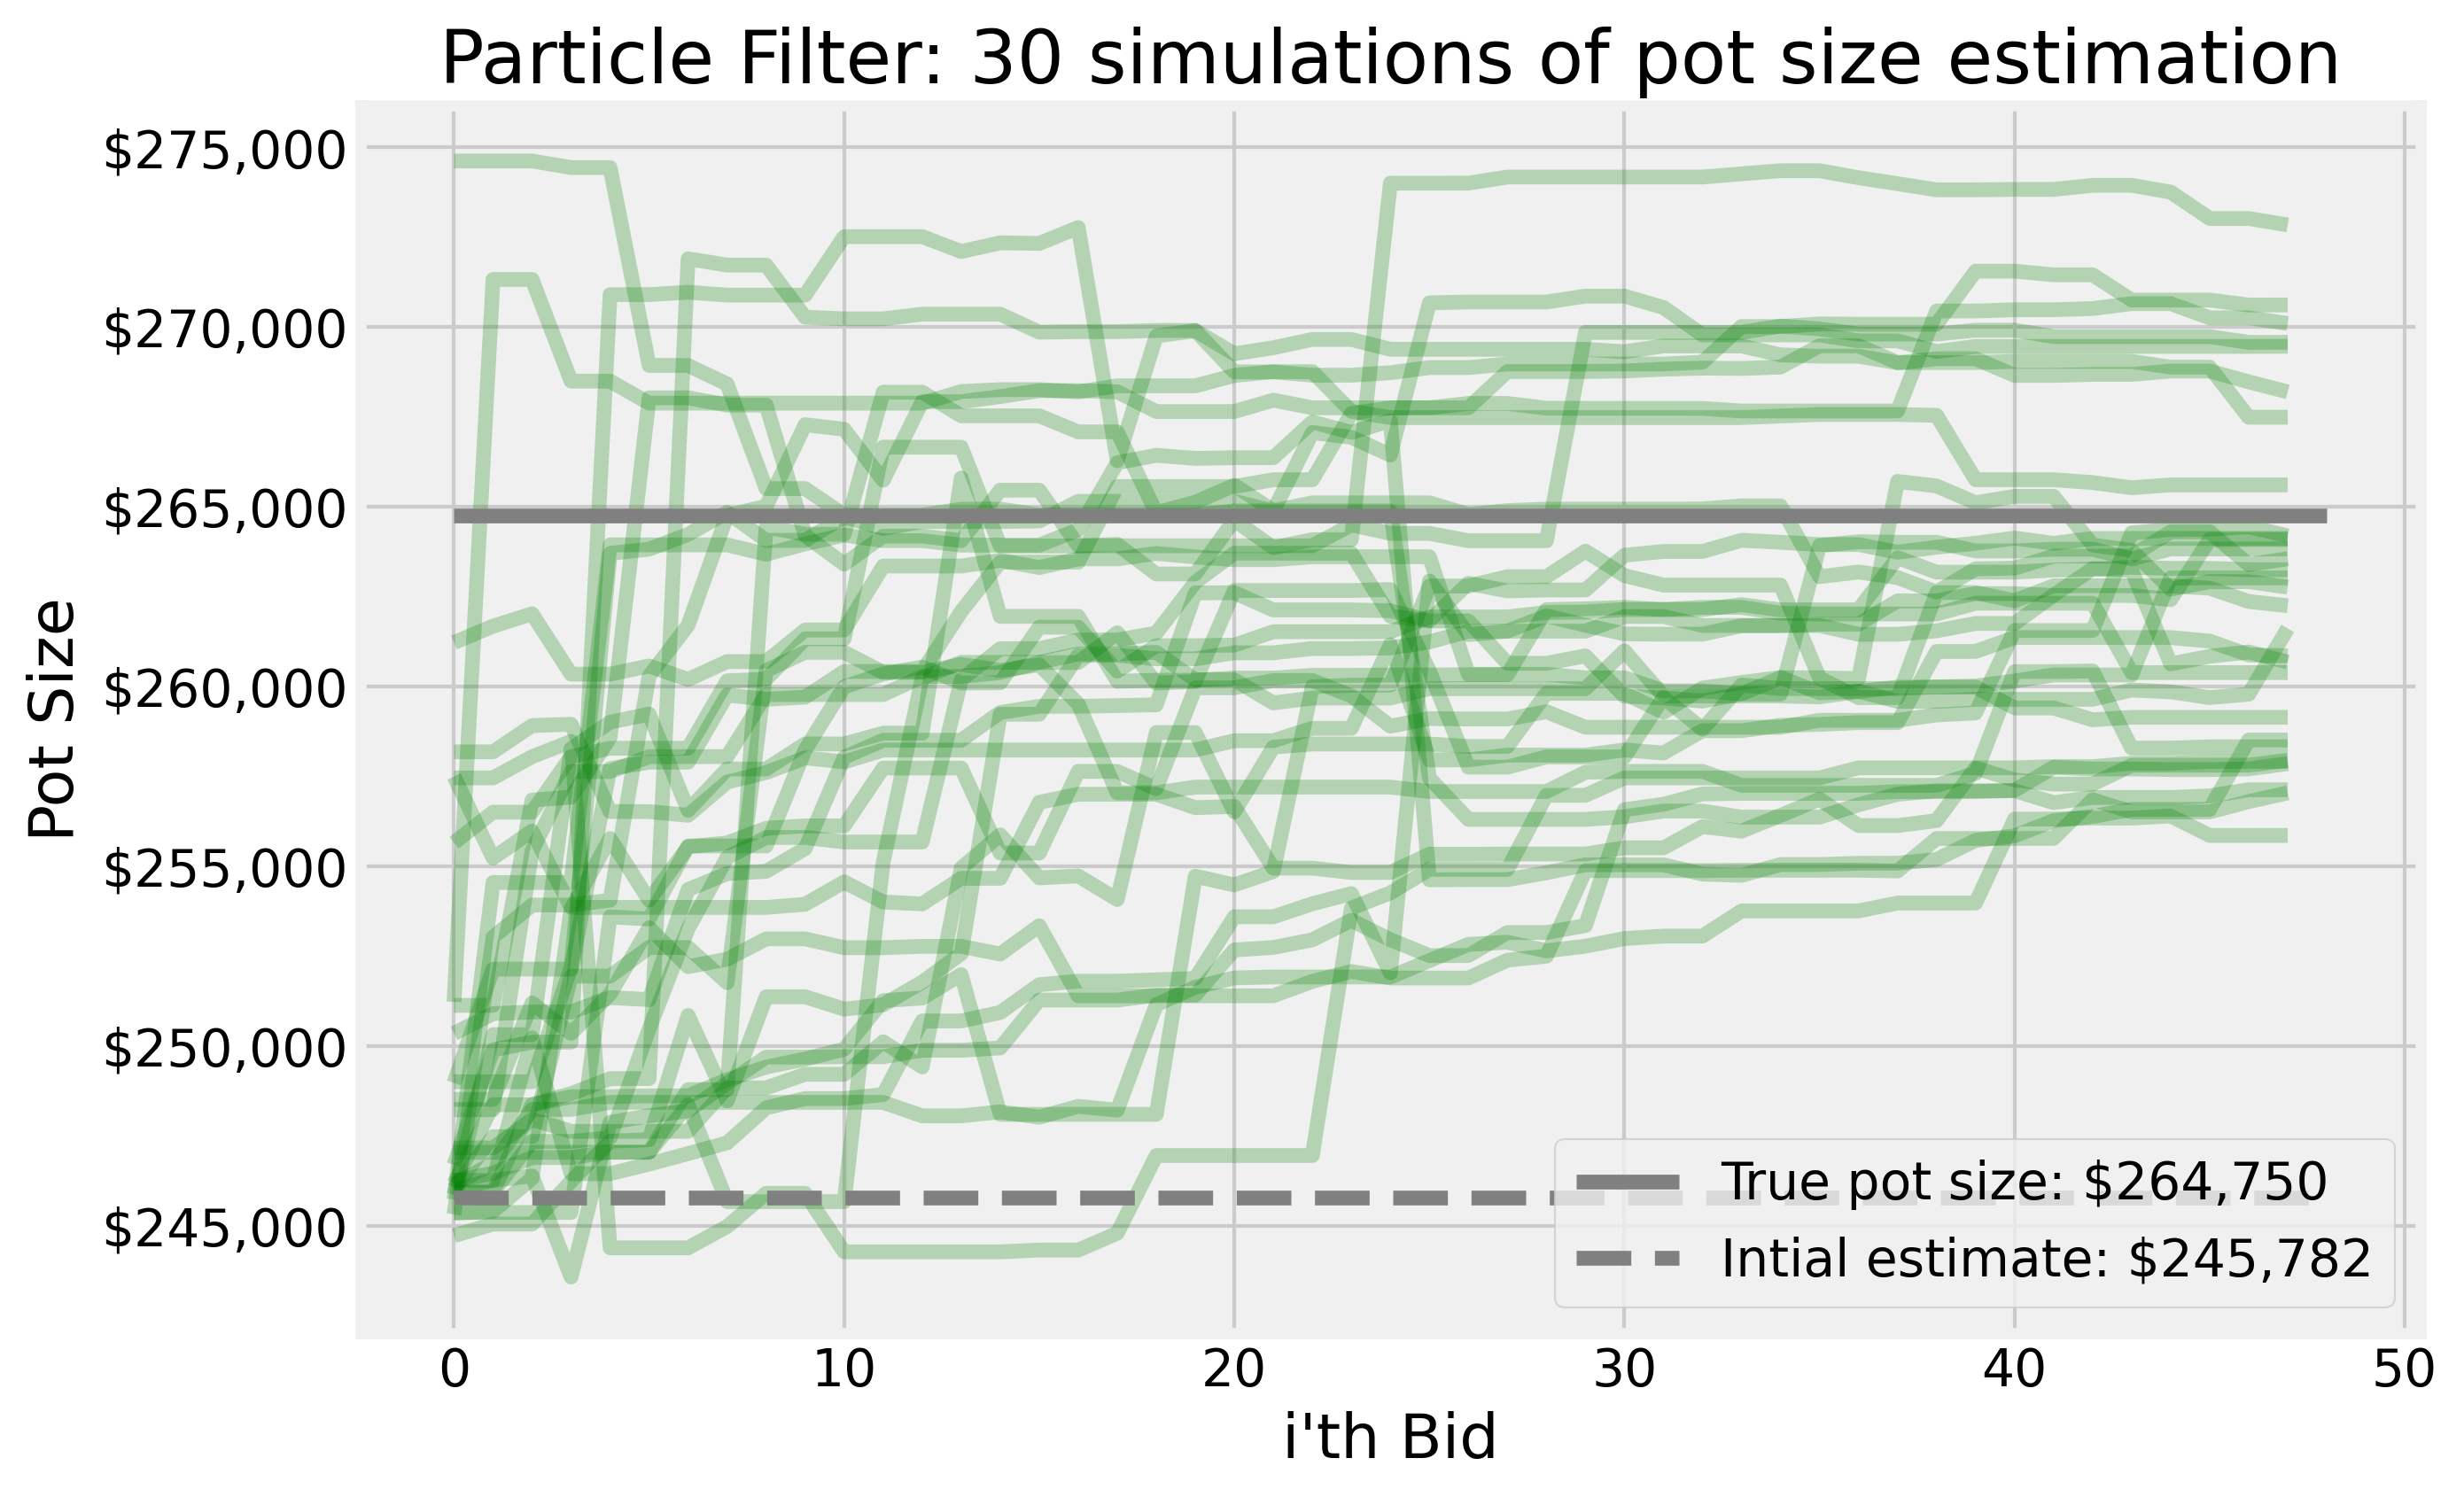

In [19]:
# visualize the results
plt.figure(figsize=(10, 6), dpi=300)
graphs_dir = "outputs"
if not os.path.exists(graphs_dir):
    os.makedirs(graphs_dir)

x_plot = np.arange(n_bids)

plt.clf()
plt.style.use("fivethirtyeight")
plt.title(f"Particle Filter: {n_simulations} simulations of pot size estimation")
plt.ylabel("Pot Size")
plt.xlabel("i'th Bid")
for i in range(n_simulations):
    plt.plot(x_plot, estimates_dic[i], color="green", alpha=0.25)
plt.hlines(
    y=true_pot_value,
    xmin=0,
    xmax=n_bids,
    colors="gray",
    label=f"True pot size: ${true_pot_value:,.0f}",
)
plt.hlines(
    y=initial_pot_guess,
    xmin=0,
    xmax=n_bids,
    colors="gray",
    linestyles="--",
    label=f"Intial estimate: ${initial_pot_guess:,.0f}",
)
plt.legend()

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"${int(x):,}"))

plt.savefig("outputs/particle_filter_model_time_series.png")
plt.show()

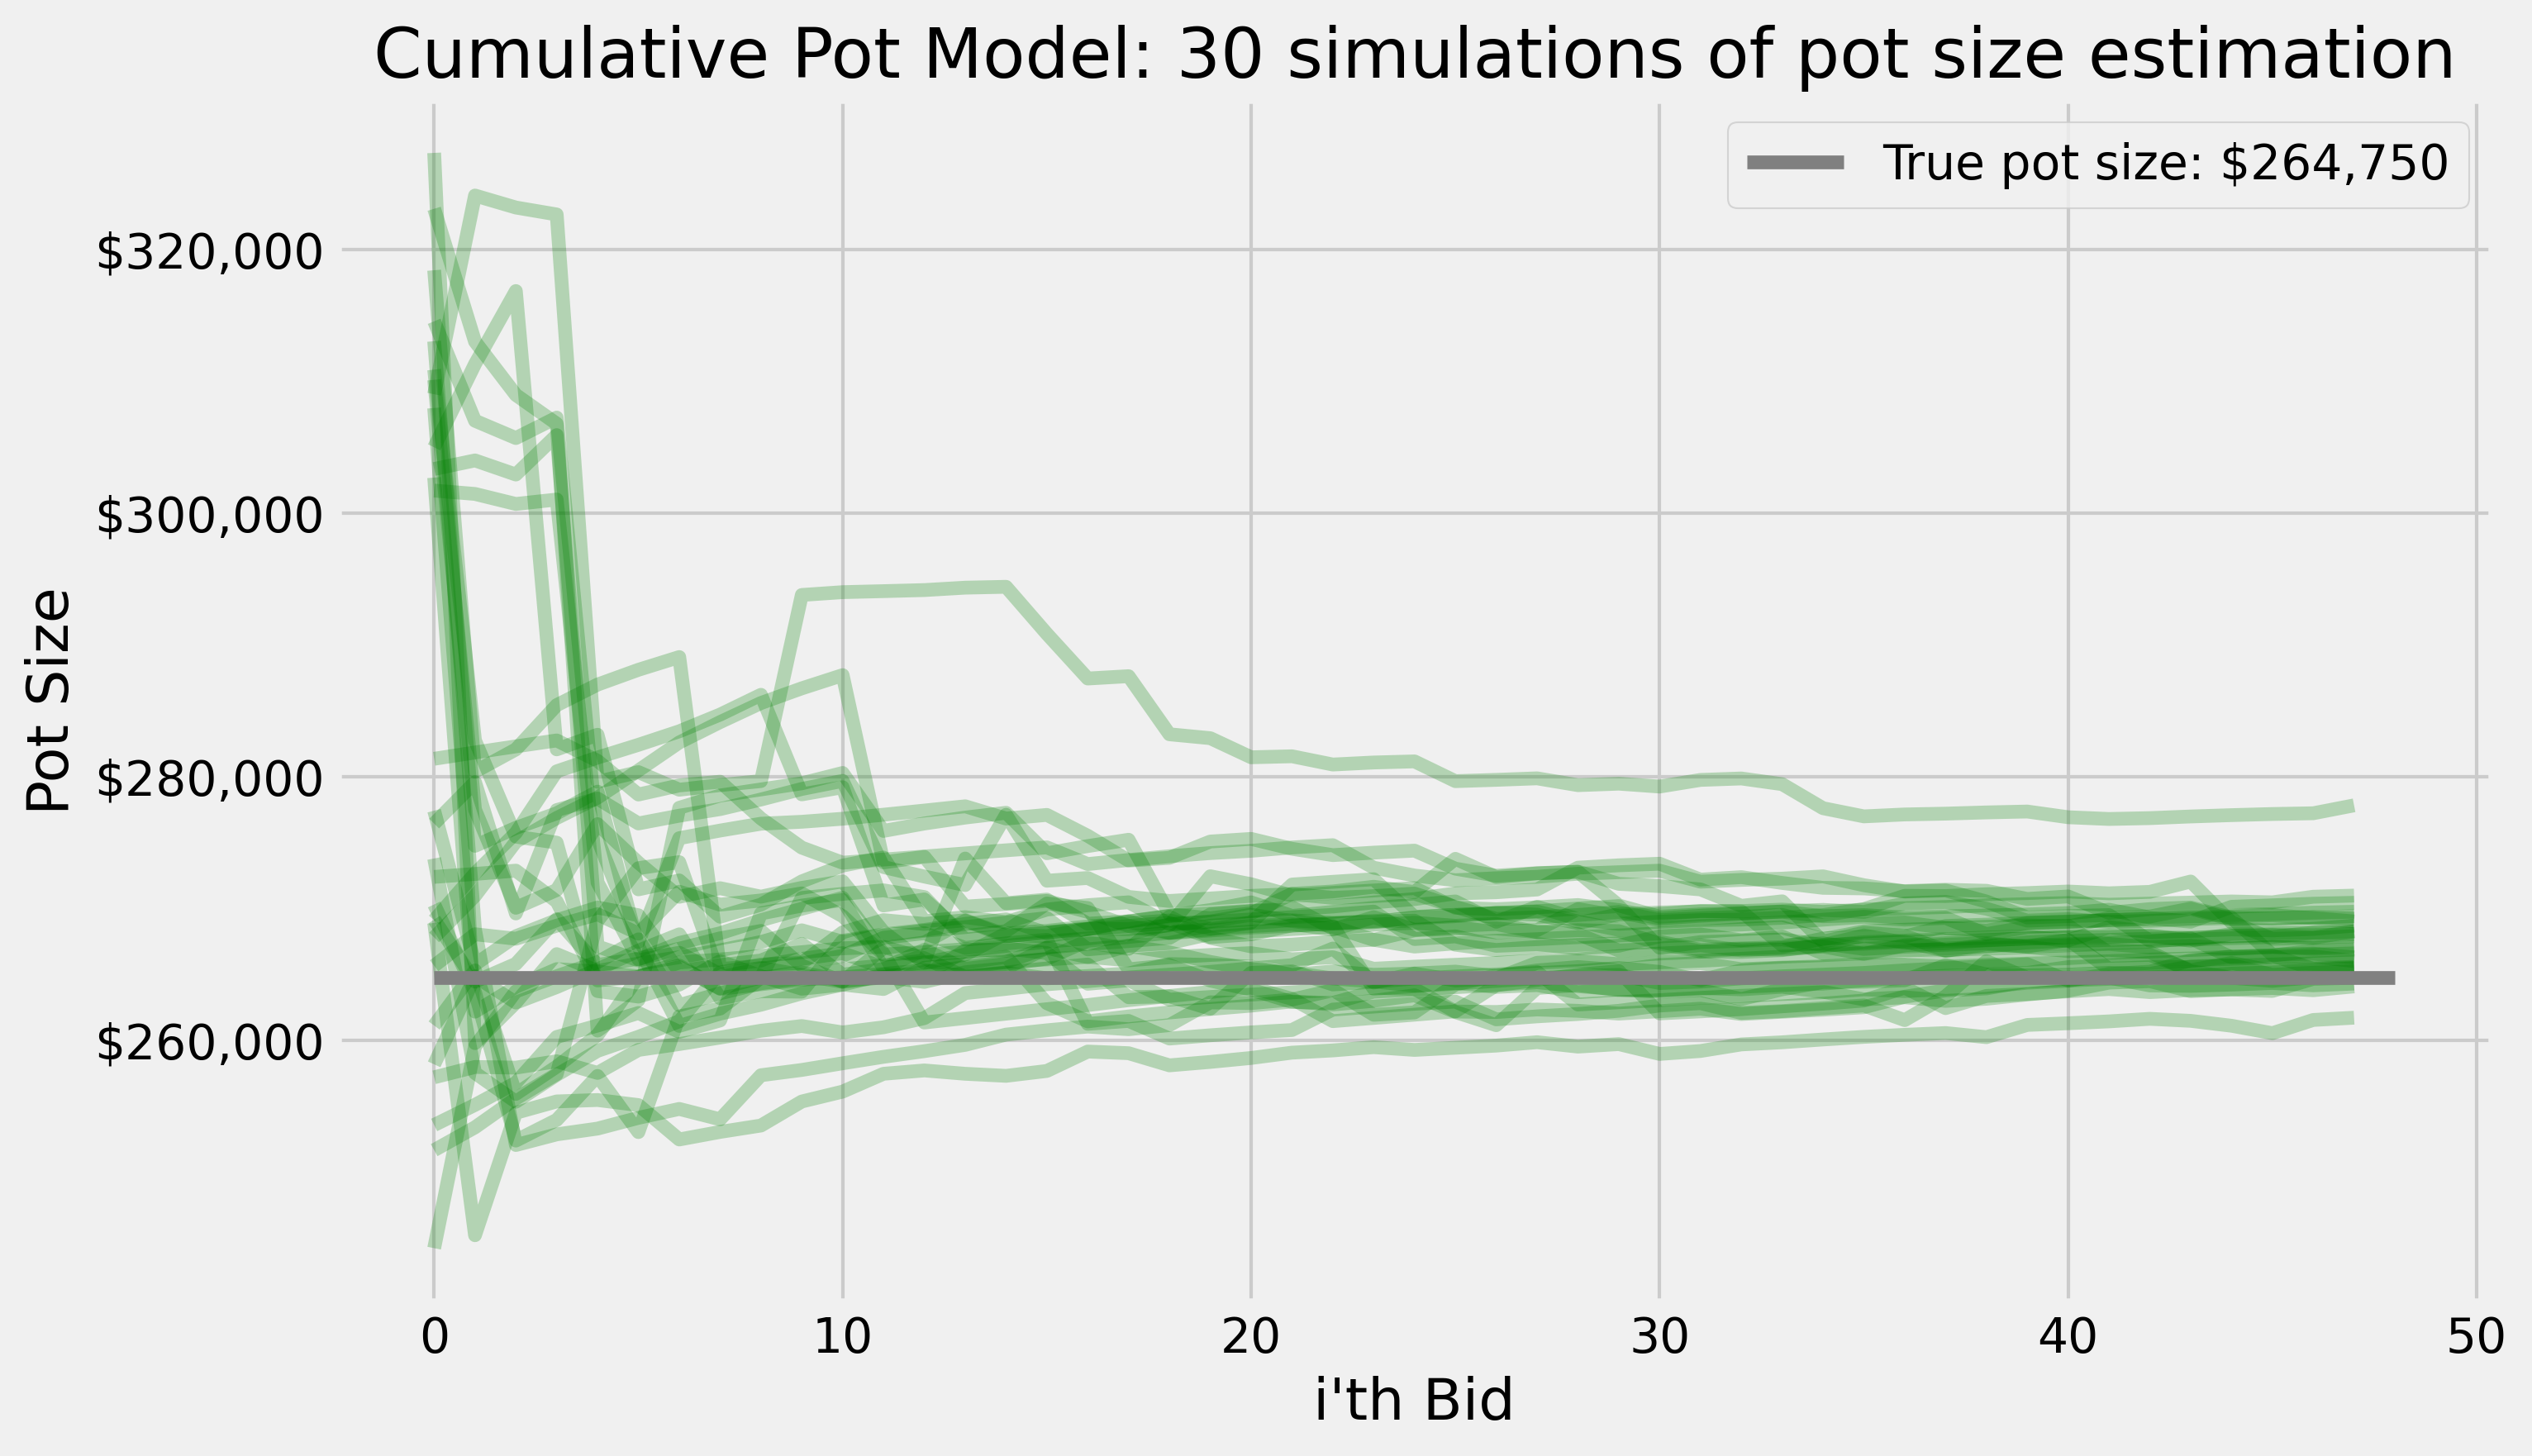

In [20]:
# visualize the results
plt.figure(figsize=(10, 6), dpi=300)
graphs_dir = "outputs"
if not os.path.exists(graphs_dir):
    os.makedirs(graphs_dir)

x_plot = np.arange(n_bids)

plt.clf()
plt.style.use("fivethirtyeight")
plt.title(f"Cumulative Pot Model: {n_simulations} simulations of pot size estimation")
plt.ylabel("Pot Size")
plt.xlabel("i'th Bid")
for i in range(n_simulations):
    plt.plot(x_plot, cumulative_estimates_dic[i], color="green", alpha=0.25)
plt.hlines(
    y=true_pot_value,
    xmin=0,
    xmax=n_bids,
    colors="gray",
    label=f"True pot size: ${true_pot_value:,.0f}",
)
plt.legend()

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"${int(x):,}"))
plt.savefig("outputs/cumulative_model_time_series.png")
plt.show()

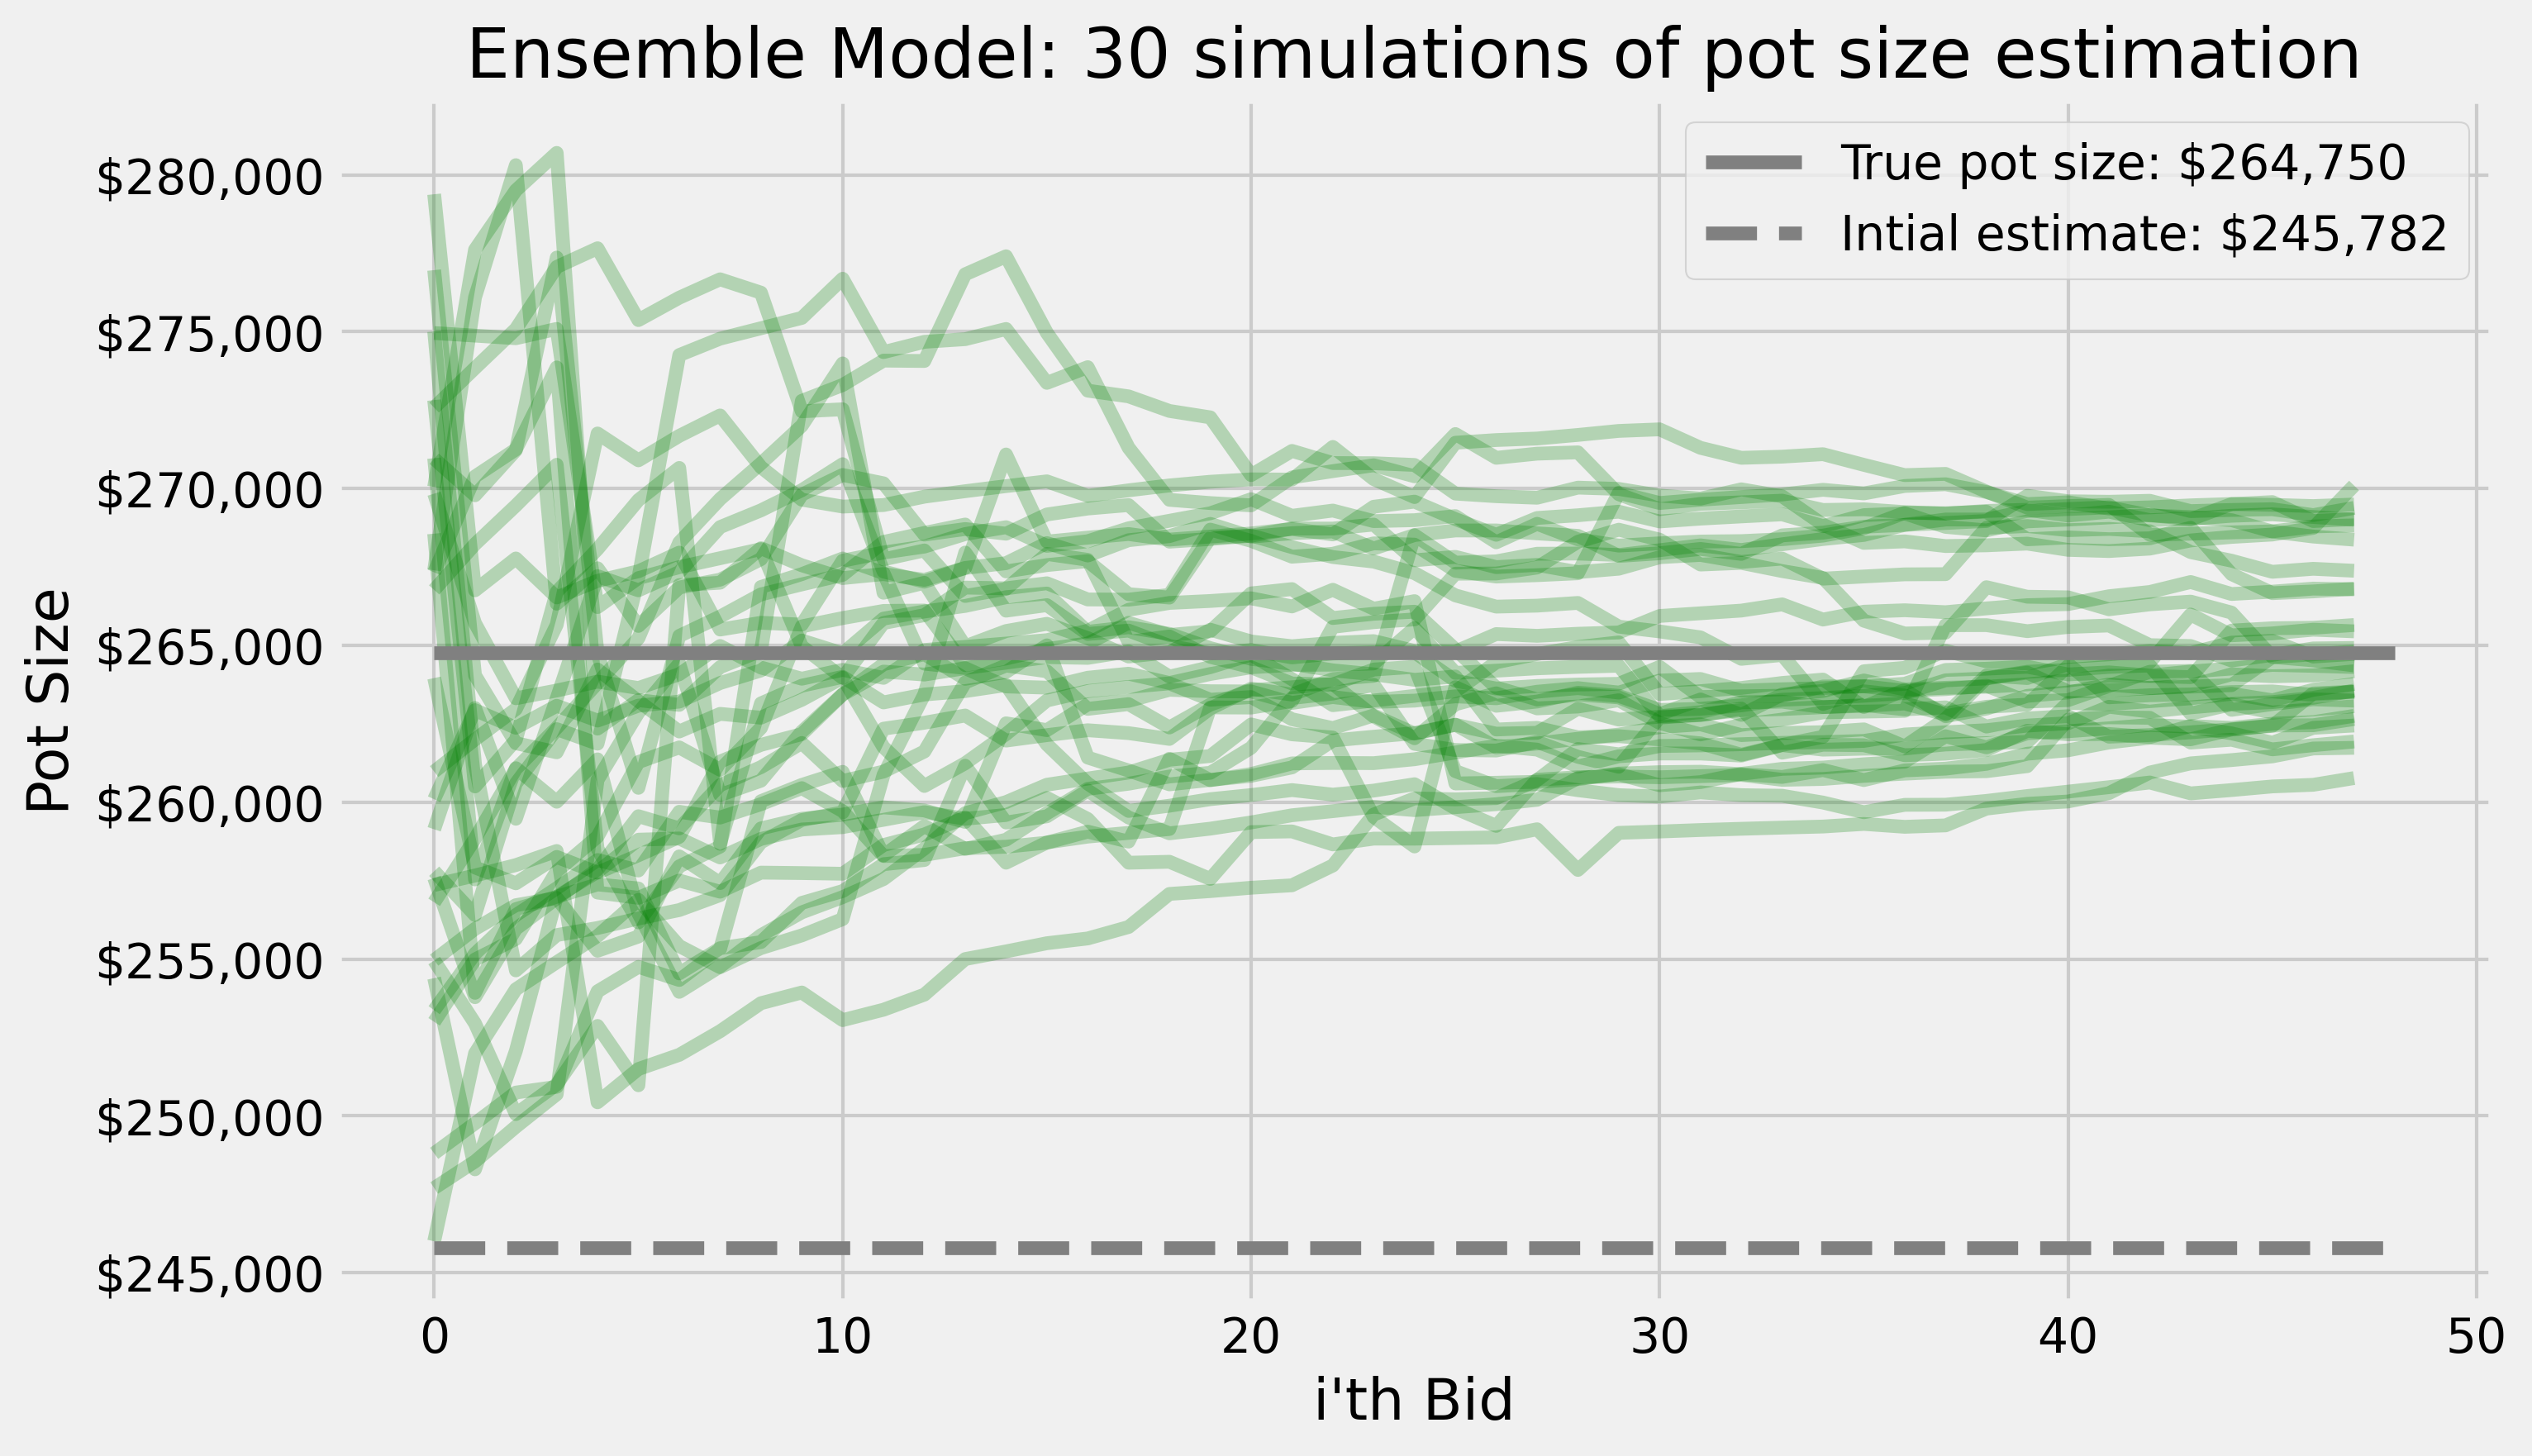

In [21]:
# visualize the results
plt.figure(figsize=(10, 6), dpi=300)
graphs_dir = "outputs"
if not os.path.exists(graphs_dir):
    os.makedirs(graphs_dir)

x_plot = np.arange(n_bids)

plt.clf()
plt.style.use("fivethirtyeight")
plt.title(f"Ensemble Model: {n_simulations} simulations of pot size estimation")
plt.ylabel("Pot Size")
plt.xlabel("i'th Bid")
for i in range(n_simulations):
    plt.plot(x_plot, ensemble_estimates[i], color="green", alpha=0.25)
plt.hlines(
    y=true_pot_value,
    xmin=0,
    xmax=n_bids,
    colors="gray",
    label=f"True pot size: ${true_pot_value:,.0f}",
)
plt.hlines(
    y=initial_pot_guess,
    xmin=0,
    xmax=n_bids,
    colors="gray",
    linestyles="--",
    label=f"Intial estimate: ${initial_pot_guess:,.0f}",
)
plt.legend()

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"${int(x):,}"))
plt.savefig("outputs/ensemble_model_time_series.png")
plt.show()

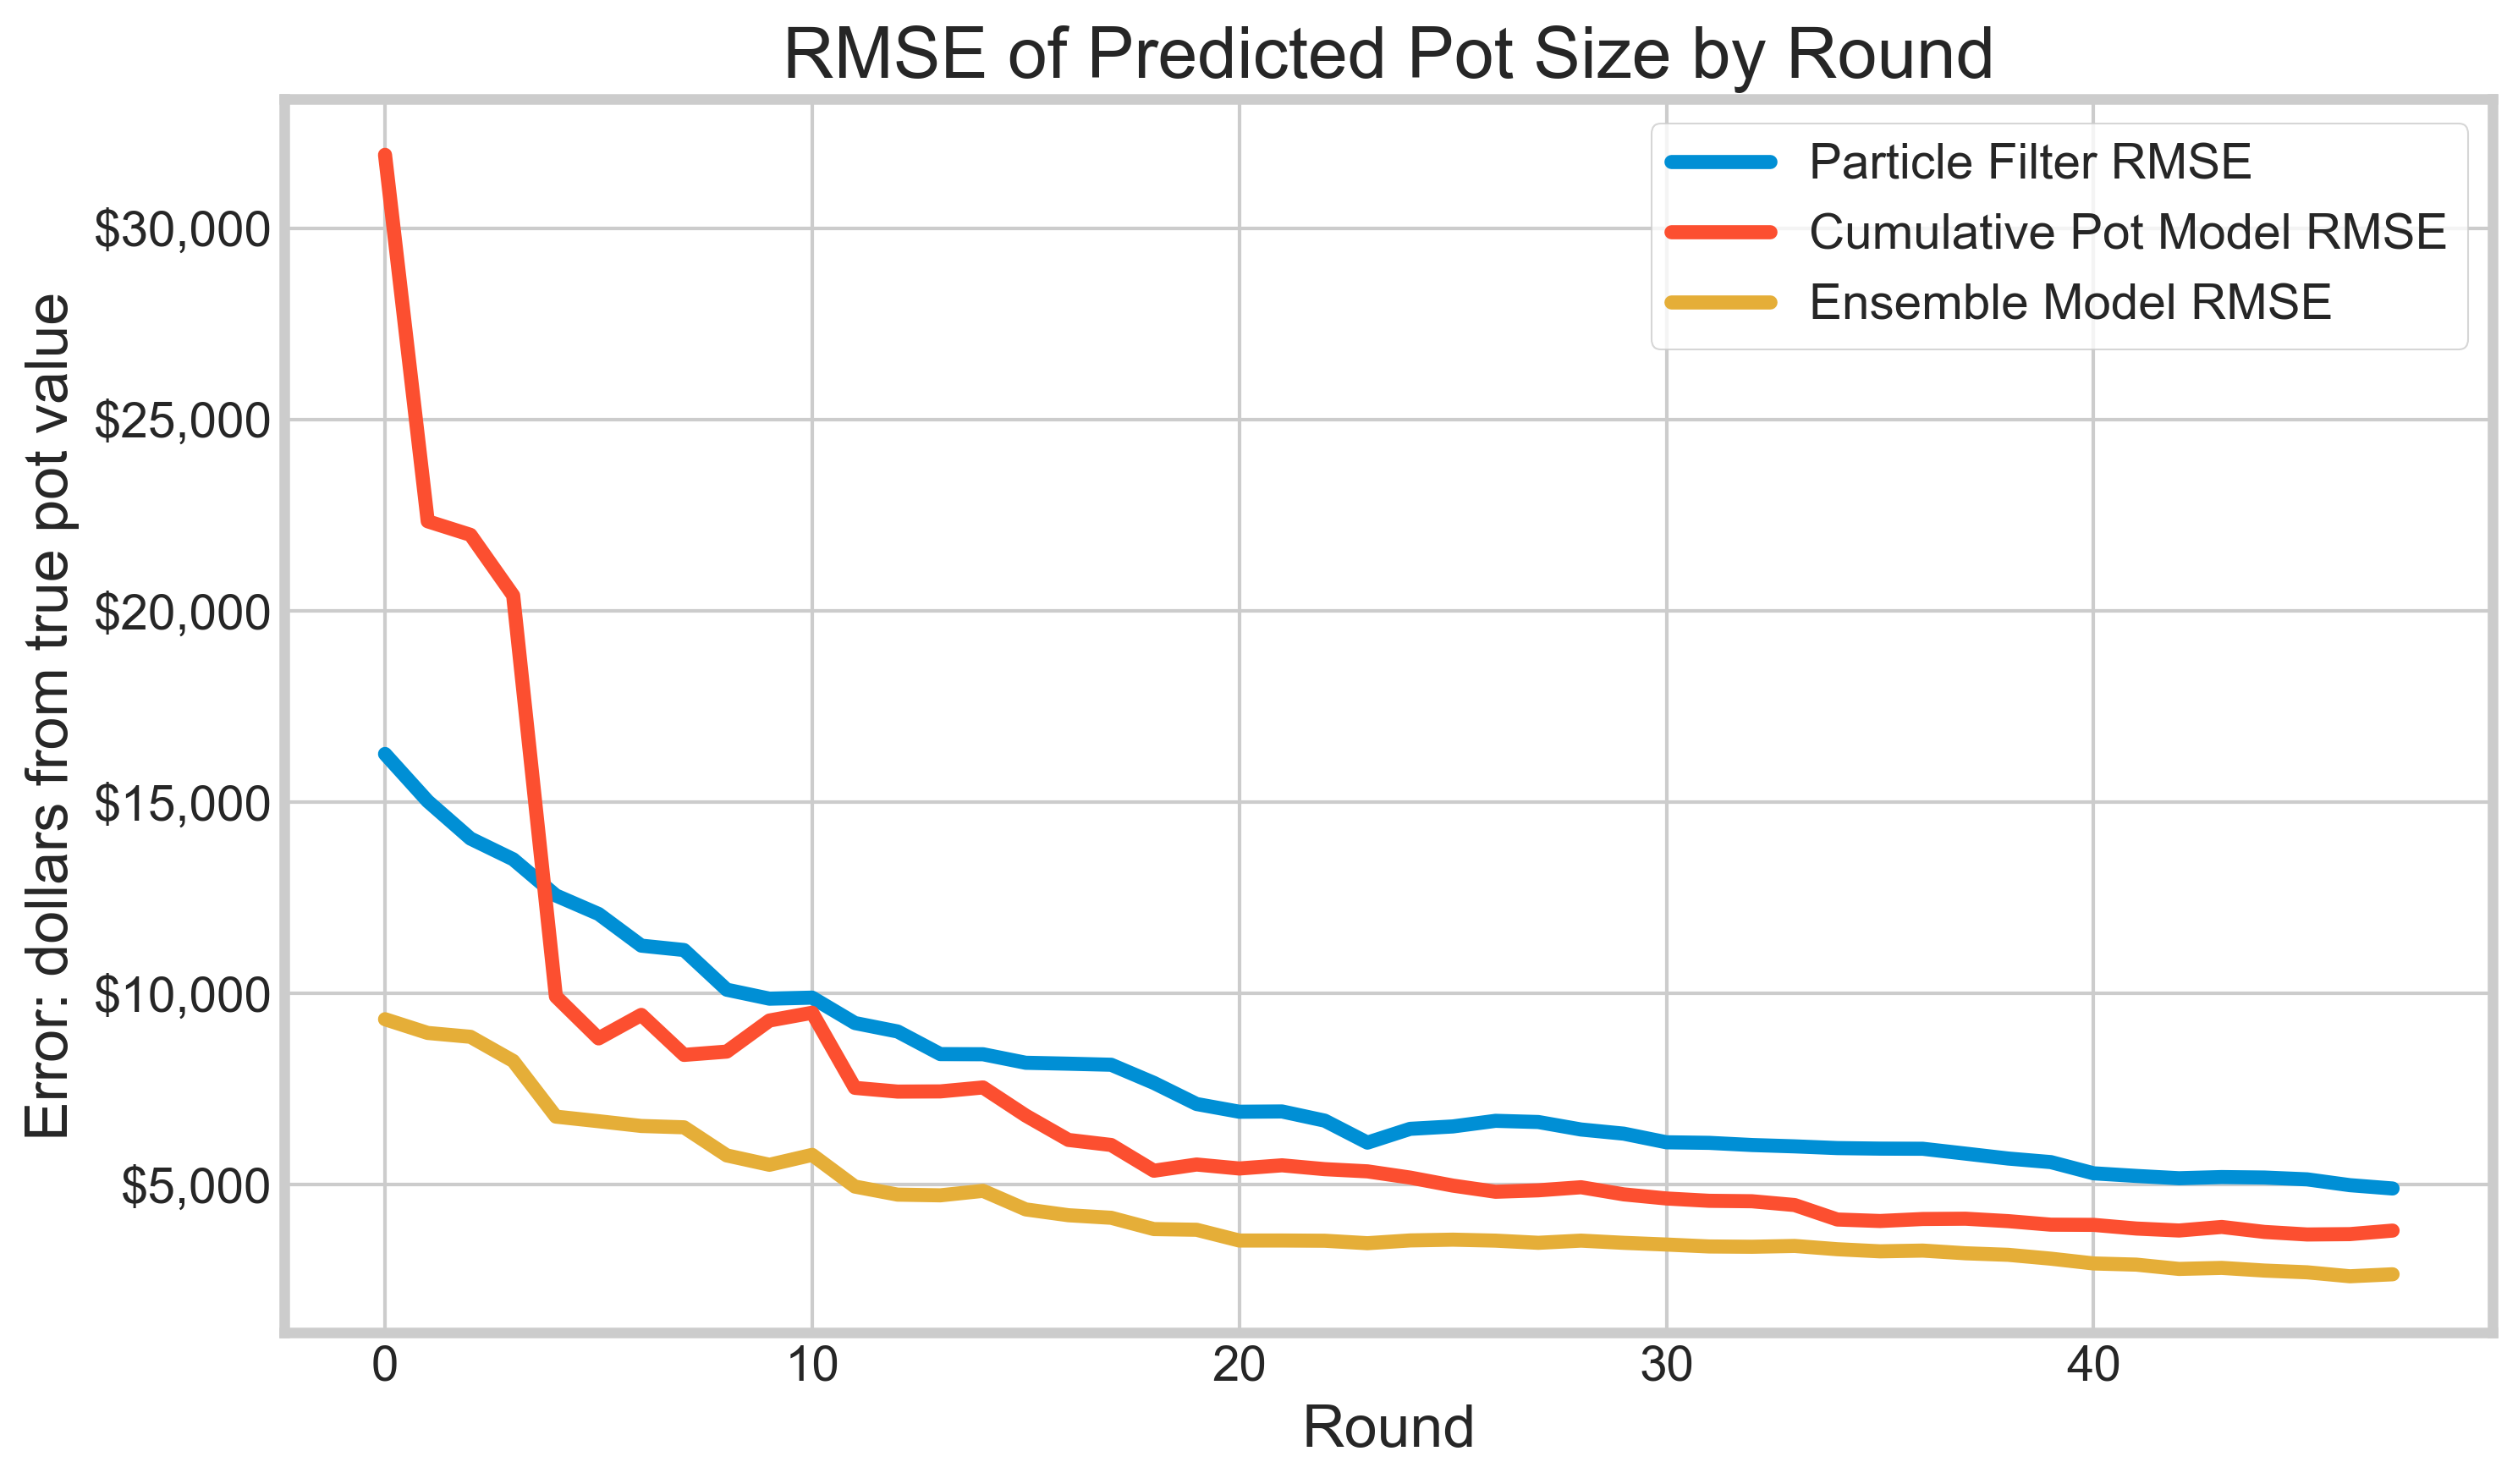

In [27]:
# plot the rmse by round
plt.figure(figsize=(10, 6), dpi=300)
plt.title("RMSE of Predicted Pot Size by Round")
plt.xlabel("Round")
plt.ylabel("Error: dollars from true pot value")
plt.plot(
    pf_rmse_by_round.keys(), pf_rmse_by_round.values(), label="Particle Filter RMSE"
)
plt.plot(
    cum_rmse_by_round.keys(),
    cum_rmse_by_round.values(),
    label="Cumulative Pot Model RMSE",
)
plt.plot(
    ensemble_rmse_by_round.keys(),
    ensemble_rmse_by_round.values(),
    label="Ensemble Model RMSE",
)
plt.legend()

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"${int(x):,}"))

plt.savefig("outputs/model_rmses.png")
plt.show()

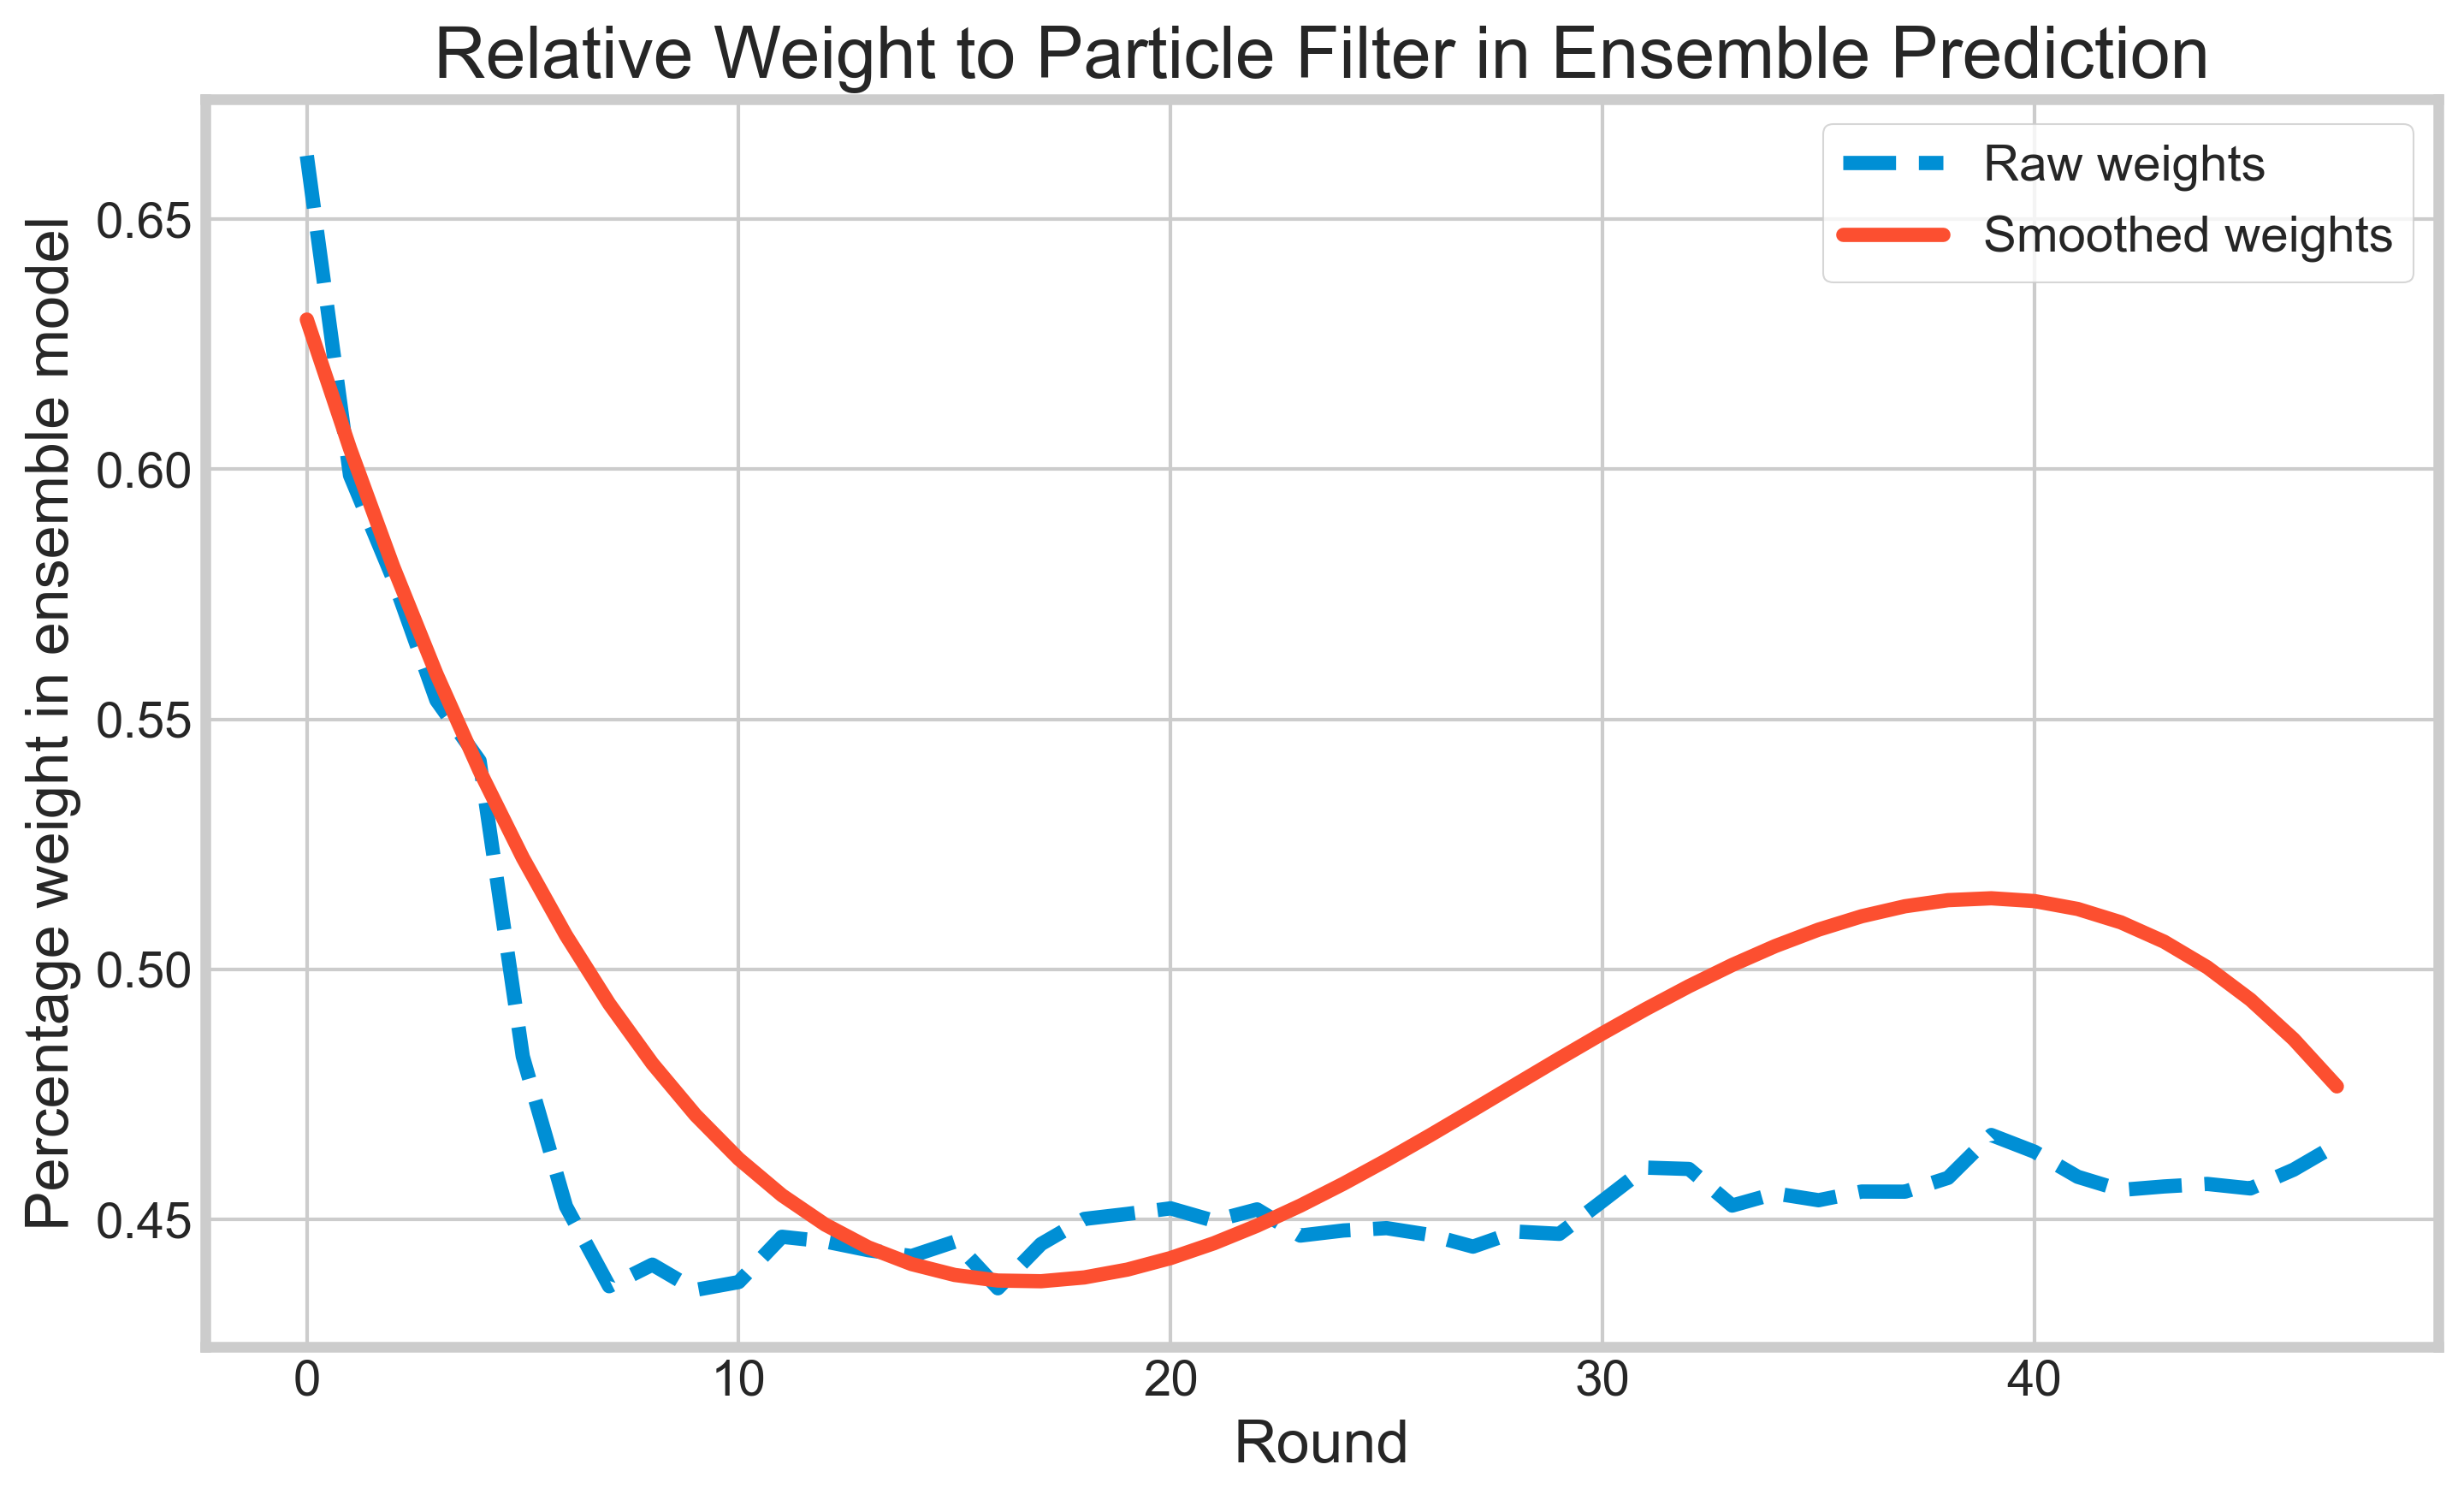

In [28]:
# plot the rmse by round
plt.figure(figsize=(10, 6), dpi=300)
plt.title("Relative Weight to Particle Filter in Ensemble Prediction")
plt.xlabel("Round")
plt.ylabel("Percentage weight in ensemble model")
plt.plot(np.arange(model_weights.size), model_weights, "--", label="Raw weights")
plt.plot(np.arange(model_weights.size), smoothed_weights, label="Smoothed weights")
plt.legend()

# ax = plt.gca()
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${int(x):,}'))

plt.savefig("outputs/model_weights.png")
plt.show()

In [24]:
# diagonostic of % valuation deviation from true value by round
for round, rmse in ensemble_rmse_by_round.items():
    if round > 15:
        break
    print(f"{1 + round}: deviation of +/- {100 * rmse/true_pot_value:.2f}%")

1: deviation of +/- 3.52%
2: deviation of +/- 3.39%
3: deviation of +/- 3.35%
4: deviation of +/- 3.11%
5: deviation of +/- 2.56%
6: deviation of +/- 2.52%
7: deviation of +/- 2.47%
8: deviation of +/- 2.46%
9: deviation of +/- 2.18%
10: deviation of +/- 2.09%
11: deviation of +/- 2.18%
12: deviation of +/- 1.87%
13: deviation of +/- 1.79%
14: deviation of +/- 1.79%
15: deviation of +/- 1.83%
16: deviation of +/- 1.65%


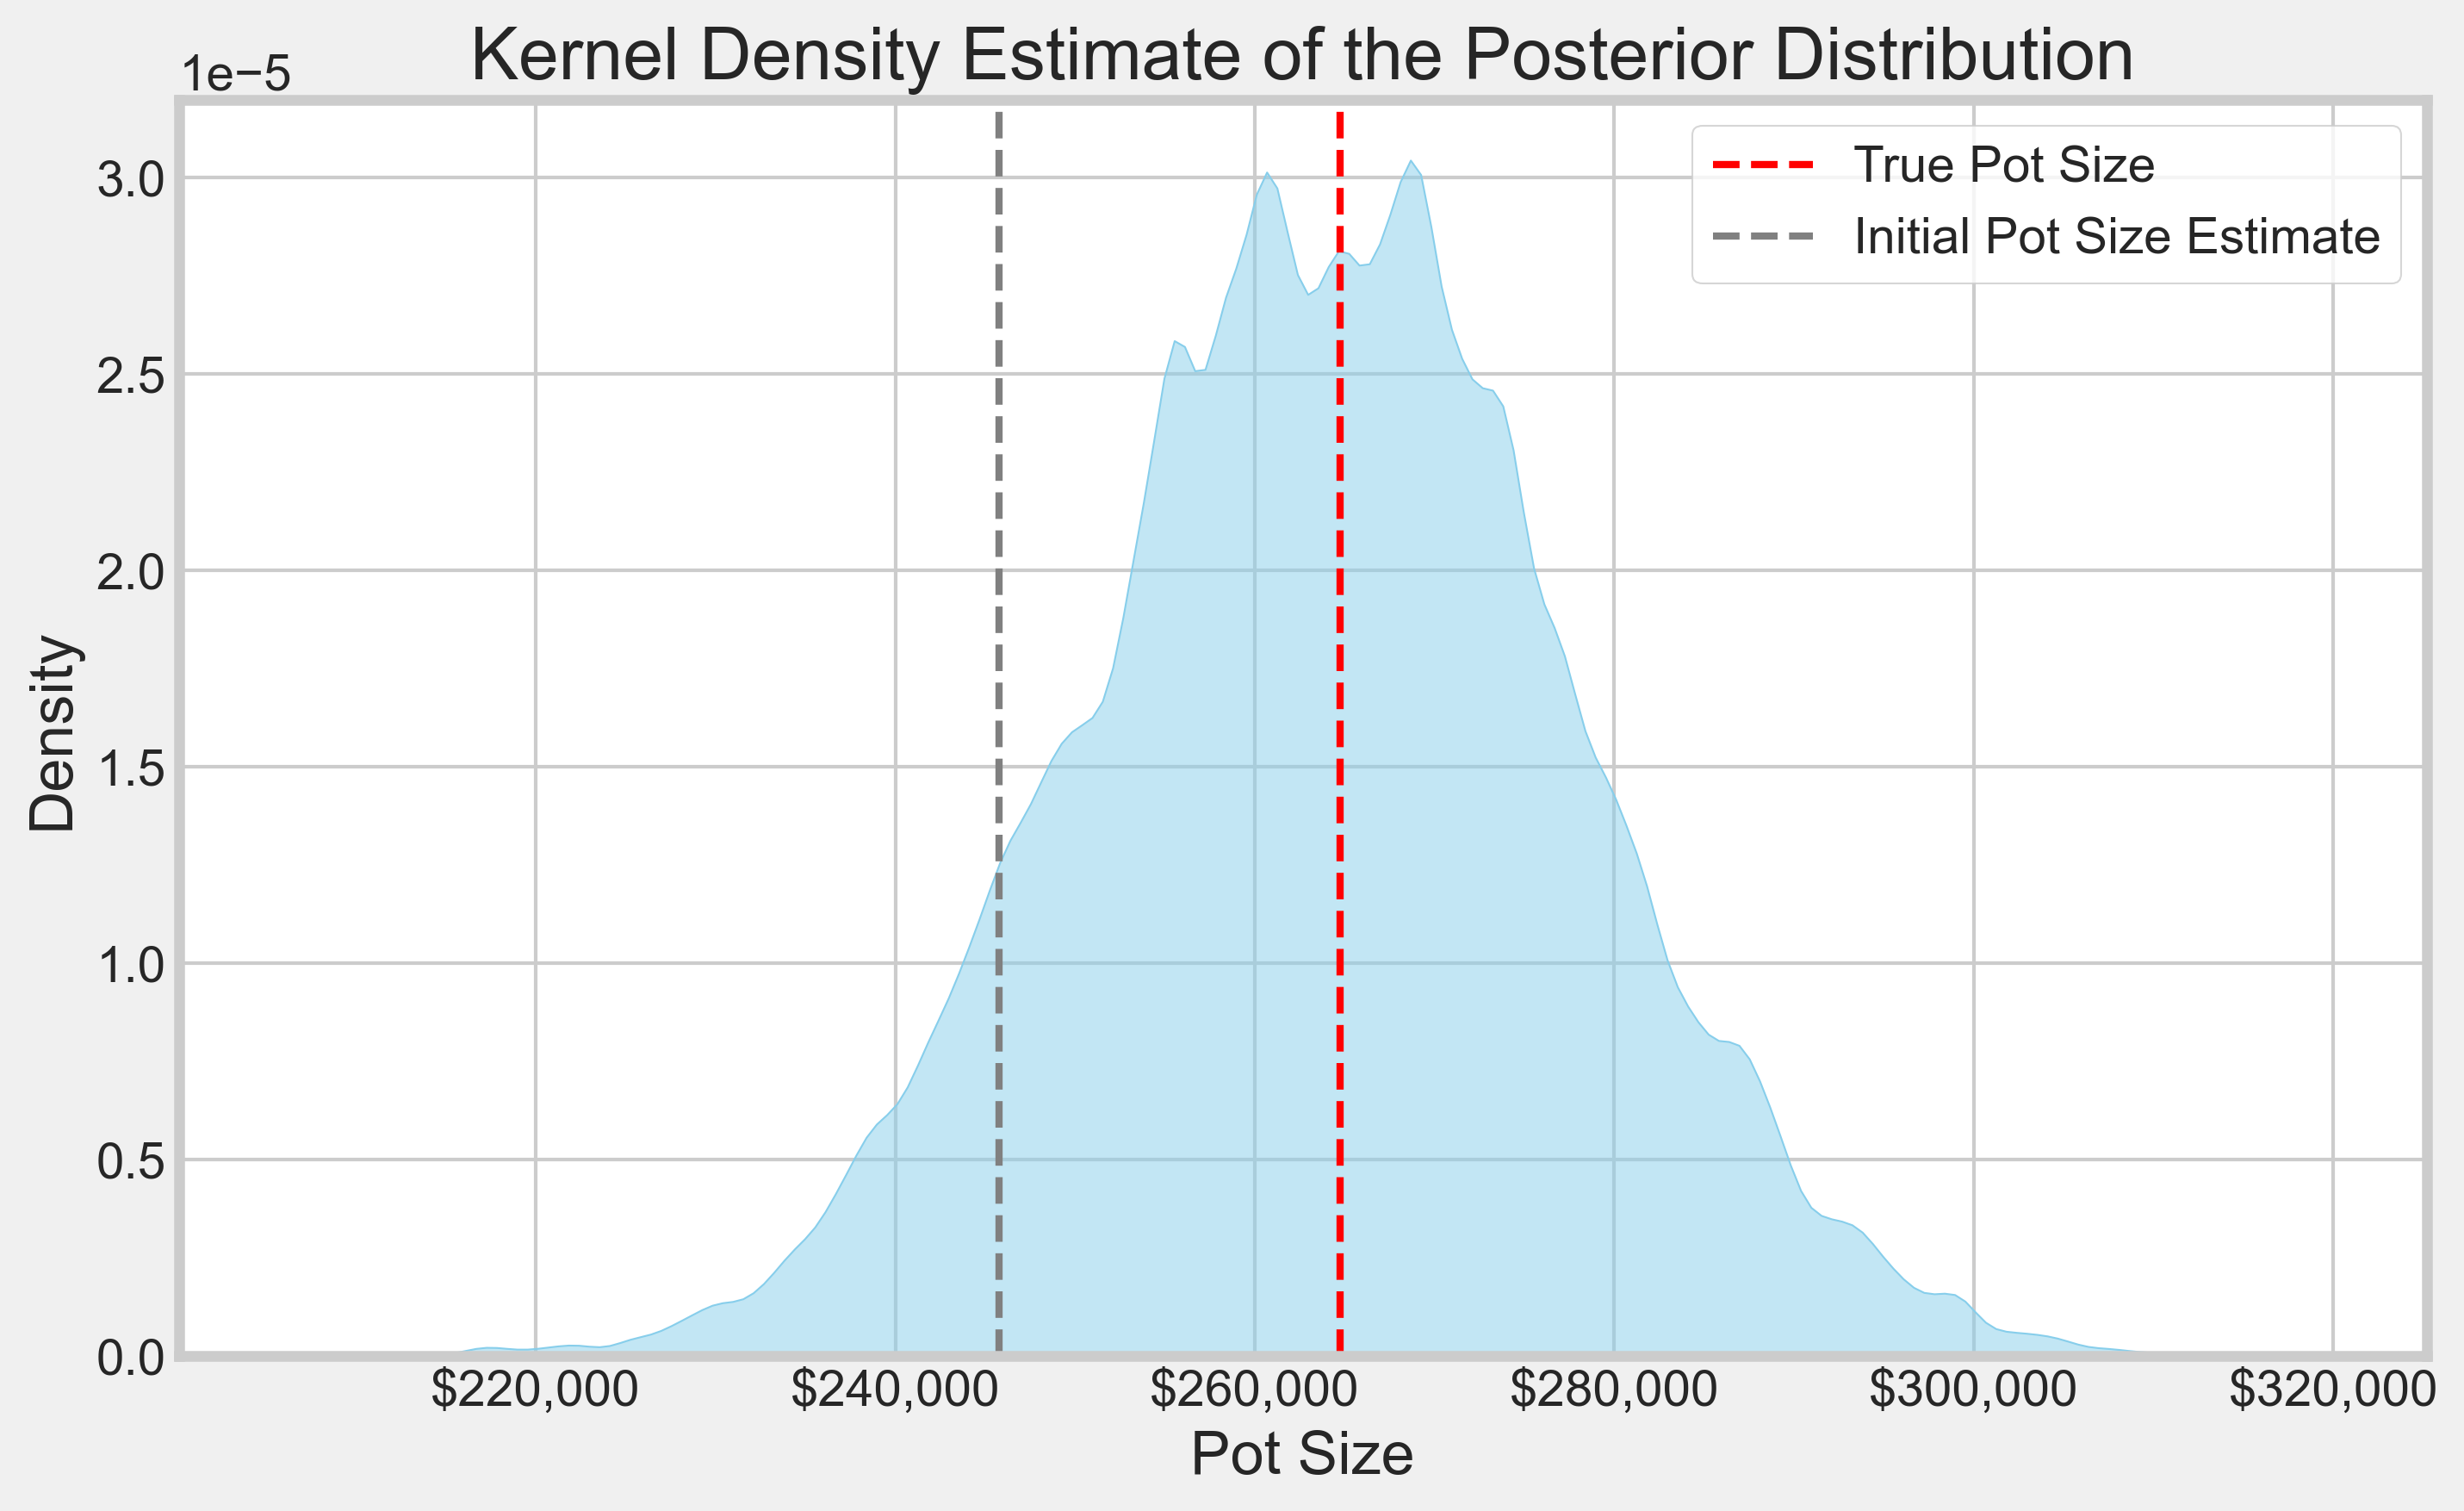

In [25]:
plt.figure(figsize=(10, 6), dpi=300)
sns.set_style("whitegrid")
# Create the KDE plot
sns.kdeplot(
    posterior_distribution, bw_adjust=0.5, fill=True, color="skyblue", alpha=0.5
)

# Add a vertical line for the true_pot_size
plt.axvline(
    x=true_pot_value, color="red", linestyle="--", linewidth=2, label="True Pot Size"
)
plt.axvline(
    x=initial_pot_guess,
    color="grey",
    linestyle="--",
    linewidth=2,
    label="Initial Pot Size Estimate",
)

# Add legend, labels, and title
plt.legend()
plt.xlabel("Pot Size")
plt.ylabel("Density")
plt.title("Kernel Density Estimate of the Posterior Distribution")

# Format the x-axis labels as currency
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"${int(x):,}"))

# Show the plot
plt.show()

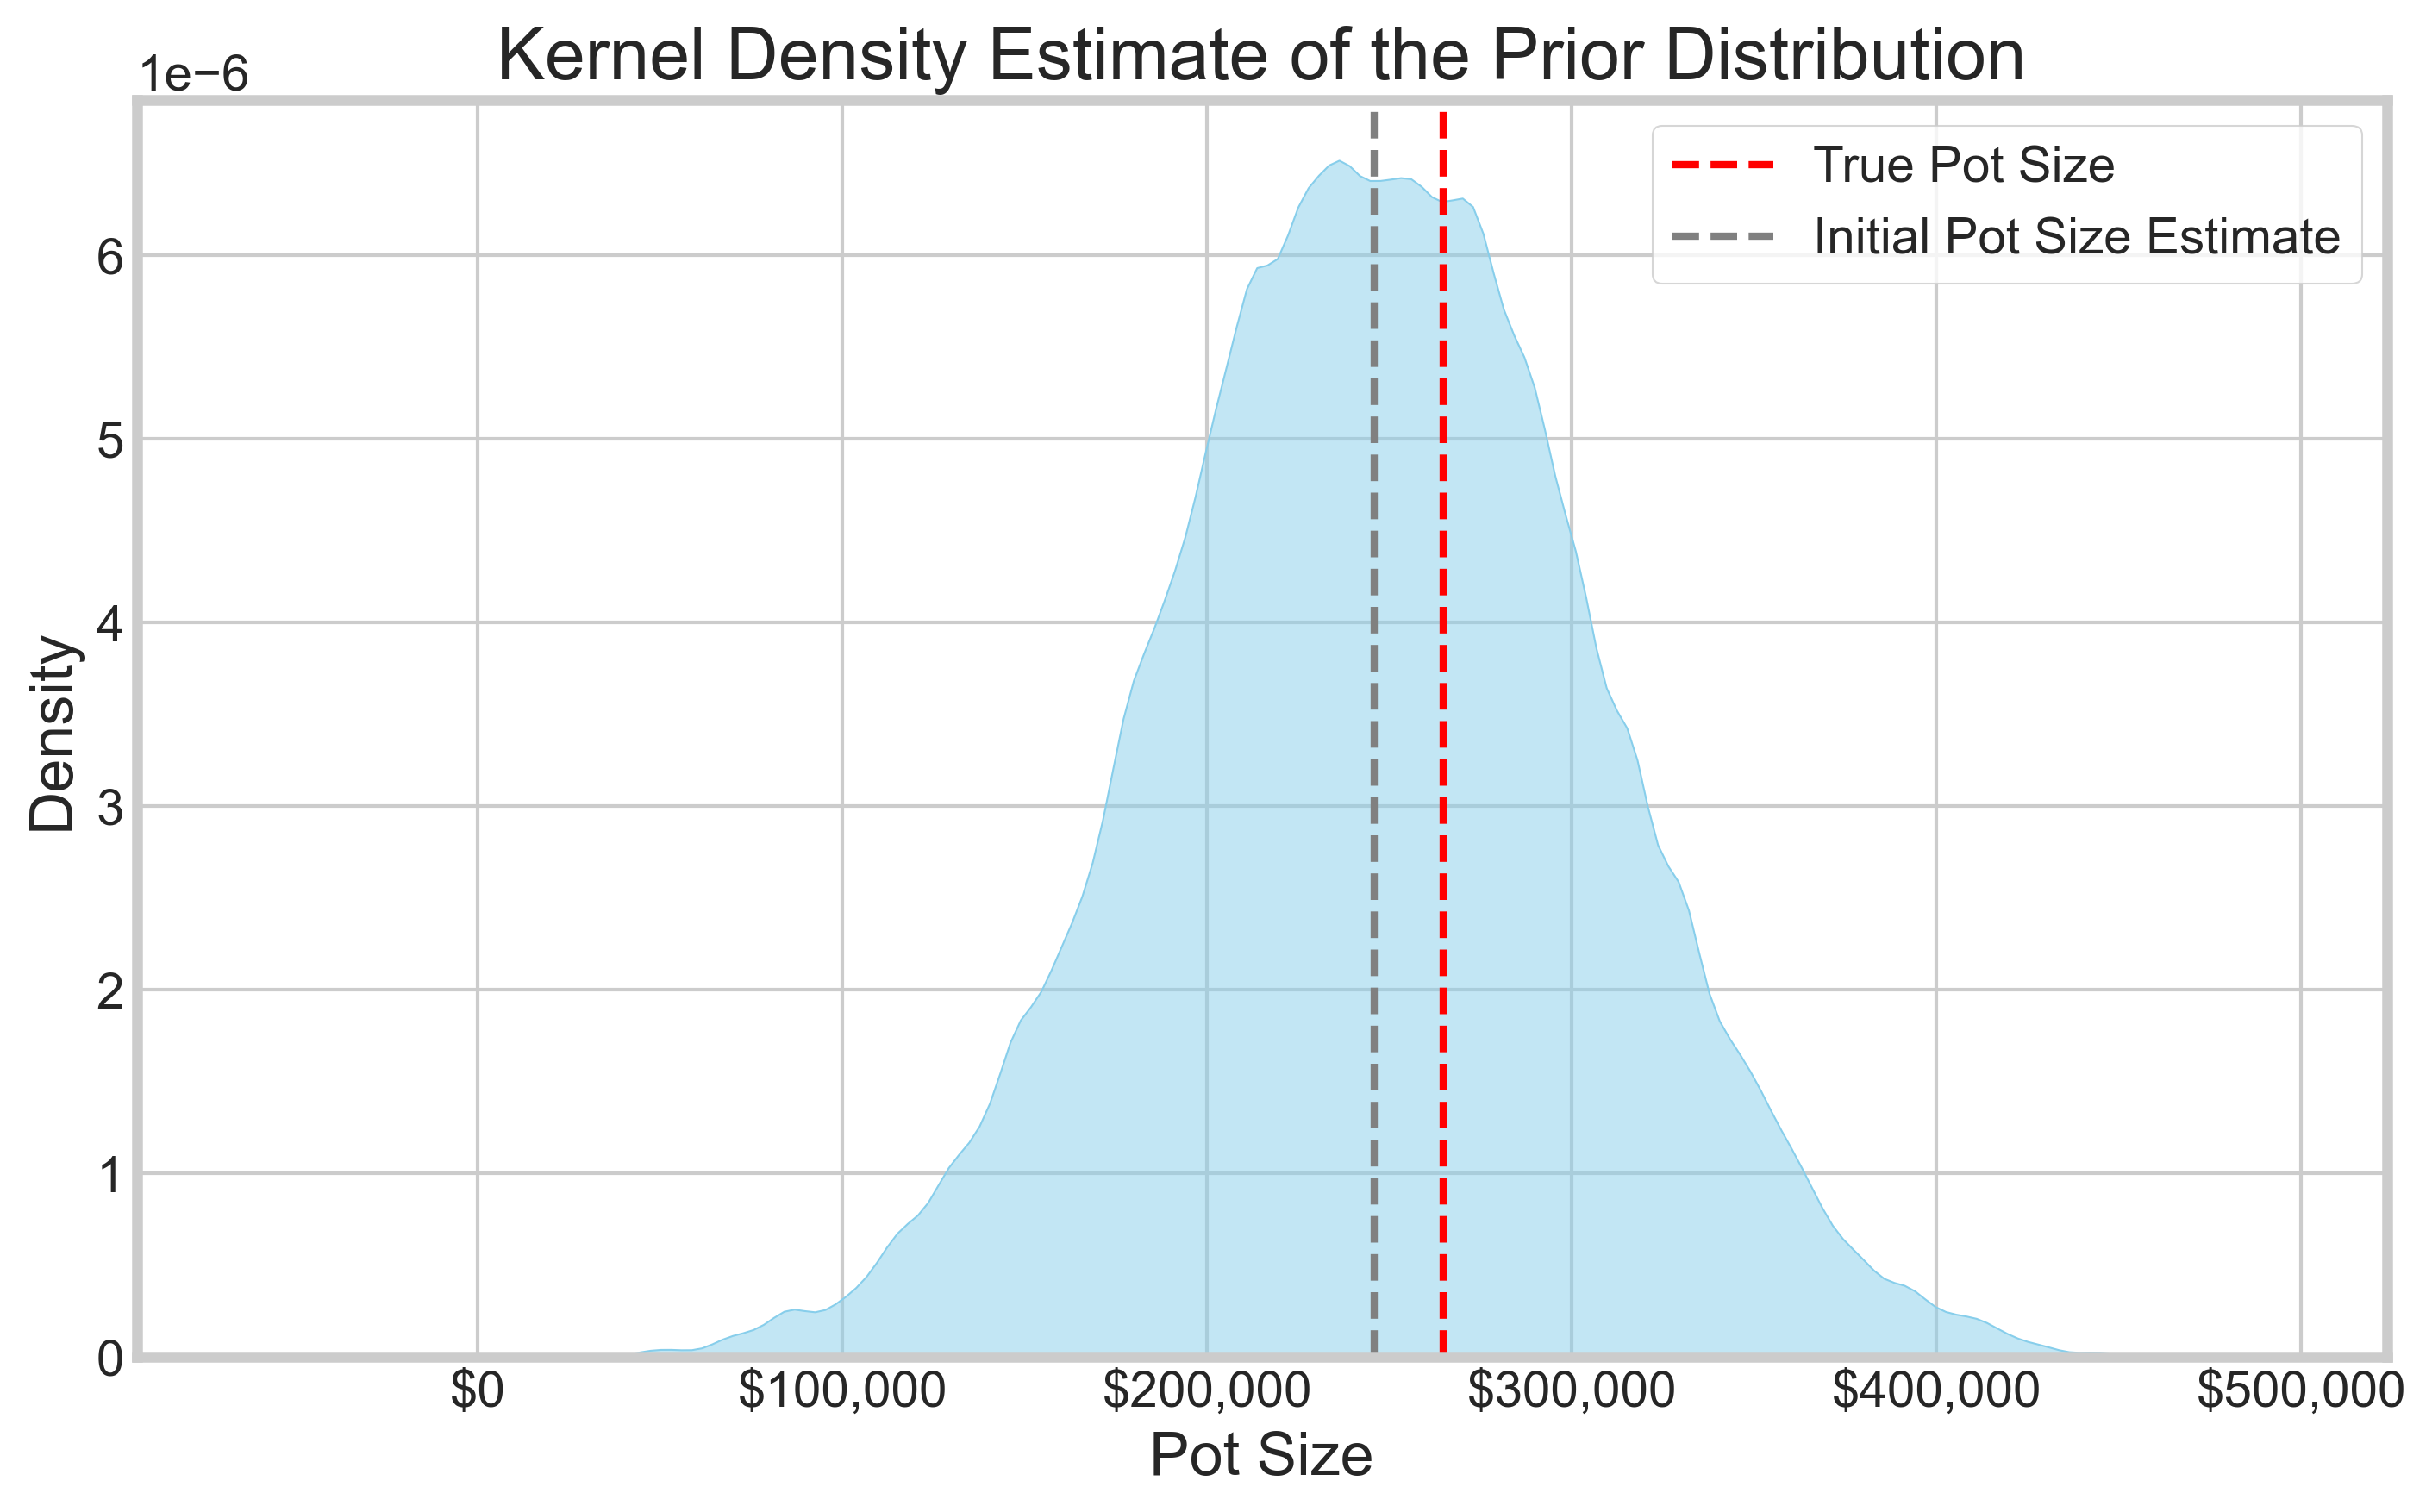

In [26]:
plt.figure(figsize=(10, 6), dpi=300)
sns.set_style("whitegrid")
# Create the KDE plot
sns.kdeplot(prior_distribution, bw_adjust=0.5, fill=True, color="skyblue", alpha=0.5)

# Add a vertical line for the true_pot_size
plt.axvline(
    x=true_pot_value, color="red", linestyle="--", linewidth=2, label="True Pot Size"
)
plt.axvline(
    x=initial_pot_guess,
    color="grey",
    linestyle="--",
    linewidth=2,
    label="Initial Pot Size Estimate",
)

# Add legend, labels, and title
plt.legend()
plt.xlabel("Pot Size")
plt.ylabel("Density")
plt.title("Kernel Density Estimate of the Prior Distribution")

# Format the x-axis labels as currency
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"${int(x):,}"))

# Show the plot
plt.show()